In [1]:
import os
import pickle 
import re
import gc

import numpy as np

from pymorphy2 import MorphAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer


from pymongo import MongoClient

from collections import defaultdict

import tqdm

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# from utility import Stemmizer
from gensim import corpora, models


import json

In [2]:
%env JOBLIB_TEMP_FOLDER=/home/willywonka0922/tmp

env: JOBLIB_TEMP_FOLDER=/home/willywonka0922/tmp


In [3]:
def read_stops():
    res = set()
    with open('stops.txt') as in_file:
        for line in in_file:
            res.add(line.strip())
    
    return res

In [4]:
# morpher = MorphAnalyzer()

# russian_stopwords = set(stopwords.words('russian'))
# english_stopwords = set(stopwords.words('english'))
# custom_stops = {'br', 'ask', 'fm', 'http', 'https', 'www', 'ru', 'com', 'vk', 'view',
#                 'vkontakte', 'd1', 'd0', 'amp', 'utm_source',  'utm_medium', 'utm_campaign'}

# stops = russian_stopwords | english_stopwords | custom_stops | read_stops()

# tokenizer = RegexpTokenizer(r'\w+')
# s = Stemmizer()

In [5]:
polit_views = {
                1 : 'Communist',
                2 : 'Socialist',
                3 : 'Moderate',
                4 : 'Liberal',
                5 : 'Conservative',
                6 : 'Monarchist',
                7 : 'Ultraconservative',
                8 : 'Apathetic',
                9 : 'Libertian'
                }

In [6]:
def create_or_load_ids_dict(db):
    if os.path.exists('ids_indices_dict.pickle'):
        with open('ids_indices_dict.pickle', 'rb') as handle:
            return pickle.load(handle)

    ids = [user['uid'] for user in db.users.find()]
    indices = list(range(len(ids)))

    dictionary = dict(zip(ids, indices))
    dictionary.update(zip(indices, ids))

    with open('ids_indices_dict.pickle', 'wb') as handle:
        pickle.dump(dictionary, handle)

    return dictionary

def create_or_load_users_to_posts(db, ids_indices_dict):
    if os.path.exists('users_to_posts.pickle'):
        with open('users_to_posts.pickle', 'rb') as handle:
            return pickle.load(handle)

    users_to_posts = defaultdict(str)

    for user_post in tqdm.tqdm_notebook(db.wall_posts.find(), total=db.wall_posts.count()):
        users_to_posts[ids_indices_dict[user_post['from_id']]] += user_post['text']

    with open('users_to_posts.pickle', 'wb') as handle:
        pickle.dump(users_to_posts, handle)

    return users_to_posts


def stemming(text):    
    return s.process(text)

def links_content_map():
    res = defaultdict(list)
    
    for link in db.links_content.find():
        res[link['url']].append(link)
    
    return res


def user_links_map():
    res = defaultdict(list)
    
    for user_links in db.links.find():
        res[user_links['uid']].append(user_links)
    
    return res


def process_user(db, uid, users_to_posts, ids_indices_dict, links_content, user_links_m):
    text = ''

    def not_none(value):
        return value if value is not None else ''

    for user_links in user_links_m[uid]:
        for user_link in user_links['links']:
            for link in links_content[user_link]:
                if link['type'] == 'sprashivai':
                    text += ' '.join(not_none(link['answers']))
                elif link['type'] == 'livejournal' or link['type'] == 'pikabu':
                    text += ' ' + not_none(link['title'])
                    text += ' ' + not_none(link['text'])
                elif link['type'] == 'youtube':
                    text += ' ' + not_none(link['description'])
                    text += ' '.join(not_none(link['tags']))
                    text += ' ' + not_none(link['name'])
                elif link['type'] == 'ali':
                    text += ' ' + not_none(link['name'])
                elif link['type'] == 'ask':
                    text += ' '.join(not_none(link['answers']))
                elif link['type'] == 'unknown':
                    text += ' ' + not_none(link['description'])
                    text += ' ' + not_none(link['title'])
                    
    for u in db.user_info.find({'uid':uid}):
        u =  defaultdict(str, u)
        
        text += ' ' + u['about']
        text += ' ' + u['quotes']
        text += ' ' + u['activities']
        text += ' ' + u['interests']
        text += ' ' + u['music']
        text += ' ' + u['movies']
        text += ' ' + u['tv']
        text += ' ' + u['books']
        
    text += ' ' + users_to_posts[ids_indices_dict[uid]]
    
    return stemming(text)

In [7]:
client = MongoClient()
db = client.ir_project

In [8]:
def read_or_create_texts():
    try:
        with open('users_texts.bin', 'rb') as in_file:
            return pickle.load(in_file)
    except:
        ids = create_or_load_ids_dict(db)
        users_to_posts = create_or_load_users_to_posts(db, ids)
        
        links_content = links_content_map()
        user_links = user_links_map()
        
        print('Total links parsed: {}'.format(len(links_content)))
        
        users_texts = dict()

        for u in tqdm.tqdm_notebook(db.users.find(no_cursor_timeout=True), total=db.users.count()):
            users_texts[u['uid']] = process_user(db, u['uid'], users_to_posts, ids, links_content, user_links)
            
        with open('users_texts.bin', 'wb') as out:
            pickle.dump(users_texts, out)
            
        return users_texts

In [9]:
TOP_WORDS = 10
TOPICS_COUNT = 20*20

In [10]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [11]:
# try:
#     tf = pickle.load(open('tf.pickle', 'rb'))
#     cv = pickle.load(open('vect.bin', 'rb'))
# except:
#     print('cannot load tf.pickle, creating it')
#     users_texts = json.load(open('forward_index.json'))
#     only_texts = [t for t in users_texts.values()]
    
#     tf_vectorizer = CountVectorizer(min_df = 10, max_df = 0.85, max_features=50000)
#     tf = tf_vectorizer.fit_transform(only_texts)
    
#     pickle.dump(tf, open('tf.pickle', 'wb'))

In [12]:
users_texts = json.load(open('forward_index.json'))

In [13]:
text_lens = {int(uid):len(t.split()) for uid, t in tqdm.tqdm_notebook(users_texts.items())}

A Jupyter Widget

In [14]:
uid_for_topics = list()

for uid, t in tqdm.tqdm_notebook(users_texts.items()):
    num_words = len(t.split())
    
    if num_words >= 10 and num_words <= 100:
        uid_for_topics.append(uid)

A Jupyter Widget

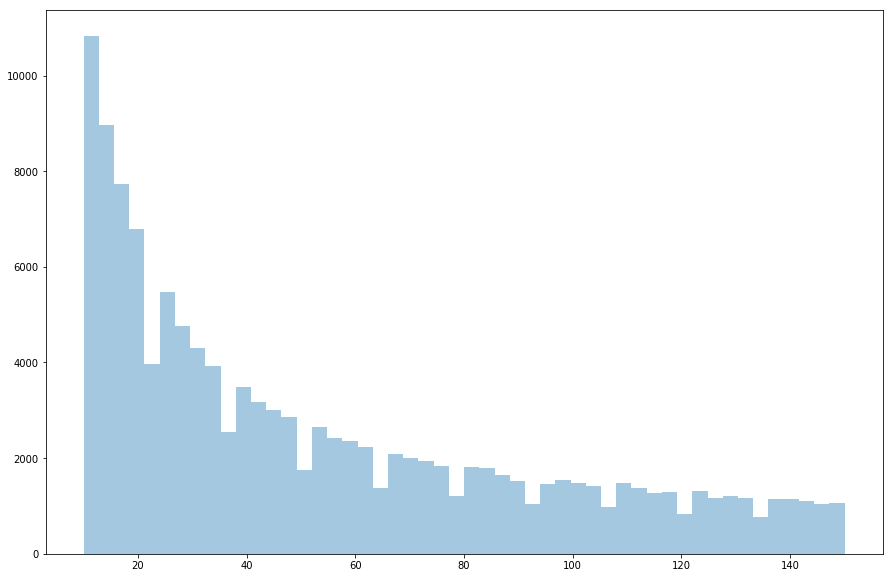

In [48]:
plt.figure(figsize=(15,10))
sns.distplot([t for t in text_lens.values() if (t <= 150) and t >= 10], kde=False)

In [16]:
only_texts = [users_texts[uid].split() for uid in tqdm.tqdm_notebook(uid_for_topics)]

A Jupyter Widget

In [17]:
dictionary = corpora.Dictionary(only_texts)

In [18]:
corpus = [dictionary.doc2bow(text) for text in tqdm.tqdm_notebook(only_texts)]

A Jupyter Widget

In [20]:
# ldamodel = models.ldamodel.LdaModel(corpus, num_topics=100, id2word = dictionary, passes=20)
ldamodel = models.ldamulticore.LdaMulticore(corpus, num_topics=100, id2word = dictionary, passes=20, workers=6)

/home/willywonka0922/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [46]:
pickle.dump(dictionary, open('gensim_dict.pickle', 'wb'))
pickle.dump(ldamodel, open('gensim_lda.pickle', 'wb'))

In [22]:
# bv = artm.BatchVectorizer(data_format='bow_n_wd',
#                           n_wd=tf,
#                           vocabulary=vocabulary)

In [25]:
# lda = LatentDirichletAllocation(n_topics=TOPICS_COUNT, max_iter=20,
#                                 learning_method='online', learning_offset=50.,
#                                 random_state=0, verbose=1, n_jobs=2).fit(tf)

In [ ]:
tf_feature_names = cv.get_feature_names()
print_top_words(lda, tf_feature_names, TOP_WORDS)

In [33]:
with open('vect.bin', 'wb') as out:
    pickle.dump(tf_vectorizer, out)
with open('lda.bin', 'wb') as out:
    pickle.dump(lda, out)

In [12]:
with open('vect.bin', 'rb') as in_file:
    vect = pickle.load(in_file)
with open('lda.bin', 'rb') as in_file:
    lda = pickle.load(in_file)

In [13]:
tf = vect.transform(only_texts)

In [14]:
topics_matrix = lda.transform(topics_matrix)

In [17]:
db.topics.insert_many([{'uid': uid, 'topics':t.tolist()} for t, uid in zip(topics_matrix, users_texts.keys())])